In [266]:
# imports
# these two lines for Kamil becouse it does not seem to work at all!
import sys
sys.path.append('c:/users/msims/appdata/roaming/python/python39/site-packages')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from gensim.models import Word2Vec
%matplotlib inline

# 1) Preparing the dataset

In [267]:
# load data
data_source = 'data/realdonaldtrump.csv'
df = pd.read_csv(data_source)
column_names = df.head(0).columns # column names
print(column_names)

Index(['id', 'link', 'content', 'date', 'retweets', 'favorites', 'mentions',
       'hashtags'],
      dtype='object')


In [268]:
print(pd.isnull(df).sum()) # empty cells in each column

id               0
link             0
content          0
date             0
retweets         0
favorites        0
mentions     22966
hashtags     37769
dtype: int64


In [269]:
print(df.shape) # number of rows and columns

(43352, 8)


In [270]:
print(df.dtypes) # column types

id            int64
link         object
content      object
date         object
retweets      int64
favorites     int64
mentions     object
hashtags     object
dtype: object


In [271]:
print(df.head()) # first 5 rows

           id                                               link  \
0  1698308935  https://twitter.com/realDonaldTrump/status/169...   
1  1701461182  https://twitter.com/realDonaldTrump/status/170...   
2  1737479987  https://twitter.com/realDonaldTrump/status/173...   
3  1741160716  https://twitter.com/realDonaldTrump/status/174...   
4  1773561338  https://twitter.com/realDonaldTrump/status/177...   

                                             content                 date  \
0  Be sure to tune in and watch Donald Trump on L...  2009-05-04 13:54:25   
1  Donald Trump will be appearing on The View tom...  2009-05-04 20:00:10   
2  Donald Trump reads Top Ten Financial Tips on L...  2009-05-08 08:38:08   
3  New Blog Post: Celebrity Apprentice Finale and...  2009-05-08 15:40:15   
4  "My persona will never be that of a wallflower...  2009-05-12 09:07:28   

   retweets  favorites mentions hashtags  
0       510        917      NaN      NaN  
1        34        267      NaN      NaN  

# 2) Visualize dataset

In [272]:
plt.rcParams["figure.figsize"] = (10, 10) 

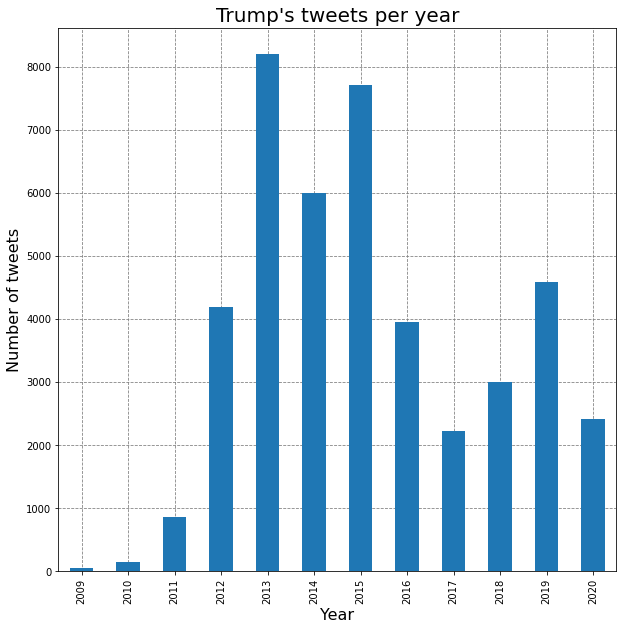

In [273]:
df['date'] = df['date'].astype('datetime64')
ax = df.groupby([df['date'].dt.year])['id'].count().plot(kind='bar')

ax.set_title('Trump\'s tweets per year', fontsize=20)
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Number of tweets', fontsize=16)

ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')

# 3) 

In [274]:
positive_words_filepath = 'data/positive-words.txt'
negative_words_filepath = 'data/negative-words.txt'

# lists containing positive and negative words
positive_words = np.loadtxt(positive_words_filepath, dtype='str', comments=';', delimiter='\n') 
negative_words = np.loadtxt(negative_words_filepath, dtype='str', comments=';', delimiter='\n')

print(positive_words)
print(negative_words)

['a+' 'abound' 'abounds' ... 'zenith' 'zest' 'zippy']
['2-faced' '2-faces' 'abnormal' ... 'zealous' 'zealously' 'zombie']


In [275]:
emb = None

In [276]:
df['content'] = df['content'].astype(str).str.lower()  # getting the context of tweet to analysis
df.head(3)

,id,link,content,date,retweets,favorites,mentions,hashtags
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,be sure to tune in and watch donald trump on l...,2009-05-04 13:54:25,510,917,NaN,NaN
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,donald trump will be appearing on the view tom...,2009-05-04 20:00:10,34,267,NaN,NaN
2,1737479987,https://twitter.com/realDonaldTrump/status/173...,donald trump reads top ten financial tips on l...,2009-05-08 08:38:08,13,19,NaN,NaN


In [277]:
#Tokenization
reqexp = nltk.tokenize.RegexpTokenizer('\w+')
df['text_token'] = df['content'].apply(reqexp.tokenize)
df.head(3)

,id,link,content,date,retweets,favorites,mentions,hashtags,text_token
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,be sure to tune in and watch donald trump on l...,2009-05-04 13:54:25,510,917,NaN,NaN,"[be, sure, to, tune, in, and, watch, donald, t..."
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,donald trump will be appearing on the view tom...,2009-05-04 20:00:10,34,267,NaN,NaN,"[donald, trump, will, be, appearing, on, the, ..."
2,1737479987,https://twitter.com/realDonaldTrump/status/173...,donald trump reads top ten financial tips on l...,2009-05-08 08:38:08,13,19,NaN,NaN,"[donald, trump, reads, top, ten, financial, ti..."


In [278]:
#StopWords
nltk.download('stopwords')
nltk.download('punkt')
stopwords = nltk.corpus.stopwords.words("english")
df['text_token'] = df['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
df.head(3)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MSIMS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MSIMS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,id,link,content,date,retweets,favorites,mentions,hashtags,text_token
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,be sure to tune in and watch donald trump on l...,2009-05-04 13:54:25,510,917,NaN,NaN,"[sure, tune, watch, donald, trump, late, night..."
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,donald trump will be appearing on the view tom...,2009-05-04 20:00:10,34,267,NaN,NaN,"[donald, trump, appearing, view, tomorrow, mor..."
2,1737479987,https://twitter.com/realDonaldTrump/status/173...,donald trump reads top ten financial tips on l...,2009-05-08 08:38:08,13,19,NaN,NaN,"[donald, trump, reads, top, ten, financial, ti..."


In [279]:
#Remove infrequent words
df['text_string'] = df['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
df[['content', 'text_token', 'text_string']].head()

,content,text_token,text_string
0,be sure to tune in and watch donald trump on l...,"[sure, tune, watch, donald, trump, late, night...",sure tune watch donald trump late night david ...
1,donald trump will be appearing on the view tom...,"[donald, trump, appearing, view, tomorrow, mor...",donald trump appearing view tomorrow morning d...
2,donald trump reads top ten financial tips on l...,"[donald, trump, reads, top, ten, financial, ti...",donald trump reads top ten financial tips late...
3,new blog post: celebrity apprentice finale and...,"[new, blog, post, celebrity, apprentice, final...",new blog post celebrity apprentice finale less...
4,"""my persona will never be that of a wallflower...","[persona, never, wallflower, rather, build, wa...",persona never wallflower rather build walls cl...


In [280]:
all_words = ' '.join([word for word in df['text_string']])
tokenized_words = nltk.tokenize.word_tokenize(all_words)
fdict = nltk.probability.FreqDist(tokenized_words)
fdict

FreqDist({'realdonaldtrump': 8788, 'com': 8318, 'great': 6774, 'trump': 6493, 'twitter': 5669, 'http': 4933, 'thank': 3060, 'president': 3053, 'https': 2928, 'people': 2740, ...})

In [281]:
df['text_string_fdist'] = df['text_token'].apply(lambda x: ' '.join([item for item in x if fdict[item] >= 3 ]))
df[['content', 'text_token', 'text_string', 'text_string_fdist']].head()

,content,text_token,text_string,text_string_fdist
0,be sure to tune in and watch donald trump on l...,"[sure, tune, watch, donald, trump, late, night...",sure tune watch donald trump late night david ...,sure tune watch donald trump late night david ...
1,donald trump will be appearing on the view tom...,"[donald, trump, appearing, view, tomorrow, mor...",donald trump appearing view tomorrow morning d...,donald trump appearing view tomorrow morning d...
2,donald trump reads top ten financial tips on l...,"[donald, trump, reads, top, ten, financial, ti...",donald trump reads top ten financial tips late...,donald trump reads top ten financial tips late...
3,new blog post: celebrity apprentice finale and...,"[new, blog, post, celebrity, apprentice, final...",new blog post celebrity apprentice finale less...,new blog post celebrity apprentice finale less...
4,"""my persona will never be that of a wallflower...","[persona, never, wallflower, rather, build, wa...",persona never wallflower rather build walls cl...,persona never rather build walls donald trump


In [282]:
#Lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MSIMS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\MSIMS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [283]:
wordnet_lem = nltk.stem.WordNetLemmatizer()
df['text_string_lem'] = df['text_string_fdist'].apply(wordnet_lem.lemmatize)

In [284]:
df['is_equal']= (df['text_string_fdist']==df['text_string_lem'])
df.is_equal.value_counts()

True     43345
False        7
Name: is_equal, dtype: int64

In [285]:
df

,id,link,content,date,retweets,favorites,mentions,hashtags,text_token,text_string,text_string_fdist,text_string_lem,is_equal
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,be sure to tune in and watch donald trump on l...,2009-05-04 13:54:25,510,917,NaN,NaN,"[sure, tune, watch, donald, trump, late, night...",sure tune watch donald trump late night david ...,sure tune watch donald trump late night david ...,sure tune watch donald trump late night david ...,True
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,donald trump will be appearing on the view tom...,2009-05-04 20:00:10,34,267,NaN,NaN,"[donald, trump, appearing, view, tomorrow, mor...",donald trump appearing view tomorrow morning d...,donald trump appearing view tomorrow morning d...,donald trump appearing view tomorrow morning d...,True
2,1737479987,https://twitter.com/realDonaldTrump/status/173...,donald trump reads top ten financial tips on l...,2009-05-08 08:38:08,13,19,NaN,NaN,"[donald, trump, reads, top, ten, financial, ti...",donald trump reads top ten financial tips late...,donald trump reads top ten financial tips late...,donald trump reads top ten financial tips late...,True
3,1741160716,https://twitter.com/realDonaldTrump/status/174...,new blog post: celebrity apprentice finale and...,2009-05-08 15:40:15,11,26,NaN,NaN,"[new, blog, post, celebrity, apprentice, final...",new blog post celebrity apprentice finale less...,new blog post celebrity apprentice finale less...,new blog post celebrity apprentice finale less...,True
4,1773561338,https://twitter.com/realDonaldTrump/status/177...,"""my persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,NaN,NaN,"[persona, never, wallflower, rather, build, wa...",persona never wallflower rather build walls cl...,persona never rather build walls donald trump,persona never rather build walls donald trump,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43347,1273405198698975232,https://twitter.com/realDonaldTrump/status/127...,joe biden was a total failure in government. h...,2020-06-17 19:00:32,23402,116377,NaN,NaN,"[joe, biden, total, failure, government, bungl...",joe biden total failure government bungled eve...,joe biden total failure government everything ...,joe biden total failure government everything ...,True
43348,1273408026968457216,https://twitter.com/realDonaldTrump/status/127...,will be interviewed on @ seanhannity tonight a...,2020-06-17 19:11:47,11810,56659,@seanhannity,NaN,"[interviewed, seanhannity, tonight, 9, 00, p, ...",interviewed seanhannity tonight enjoy,interviewed seanhannity tonight enjoy,interviewed seanhannity tonight enjoy,True
43349,1273442195161387008,https://twitter.com/realDonaldTrump/status/127...,pic.twitter.com/3lm1spbu8x,2020-06-17 21:27:33,4959,19344,NaN,NaN,"[pic, twitter, com, 3lm1spbu8x]",pic twitter com 3lm1spbu8x,pic twitter com,pic twitter com,True
43350,1273442469066276864,https://twitter.com/realDonaldTrump/status/127...,pic.twitter.com/vpce5maduz,2020-06-17 21:28:38,4627,17022,NaN,NaN,"[pic, twitter, com, vpce5maduz]",pic twitter com vpce5maduz,pic twitter com,pic twitter com,True


(-0.5, 599.5, 399.5, -0.5)

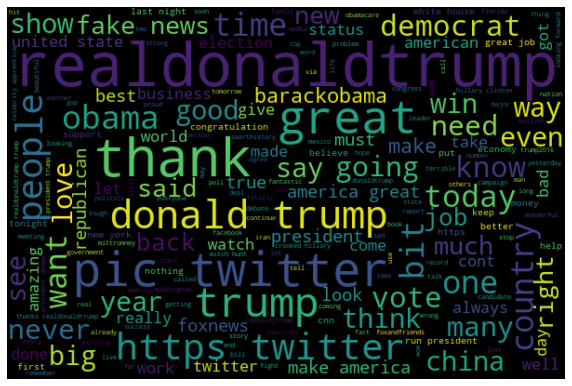

In [286]:
#Word cloud
import wordcloud
all_words_lem = ' '.join([word for word in df['text_string_lem']])
wordcloud = wordcloud.WordCloud(width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate(all_words_lem)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

In [287]:
#Sentiment analysis
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\MSIMS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [288]:
from nltk.sentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [289]:
df['polarity'] = df['text_string_lem'].apply(lambda x: analyzer.polarity_scores(x))
df.tail(3)

,id,link,content,date,retweets,favorites,mentions,hashtags,text_token,text_string,text_string_fdist,text_string_lem,is_equal,polarity
43349,1273442195161387008,https://twitter.com/realDonaldTrump/status/127...,pic.twitter.com/3lm1spbu8x,2020-06-17 21:27:33,4959,19344,NaN,NaN,"[pic, twitter, com, 3lm1spbu8x]",pic twitter com 3lm1spbu8x,pic twitter com,pic twitter com,True,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
43350,1273442469066276864,https://twitter.com/realDonaldTrump/status/127...,pic.twitter.com/vpce5maduz,2020-06-17 21:28:38,4627,17022,NaN,NaN,"[pic, twitter, com, vpce5maduz]",pic twitter com vpce5maduz,pic twitter com,pic twitter com,True,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
43351,1273442528411385858,https://twitter.com/realDonaldTrump/status/127...,pic.twitter.com/vllc0bhw41,2020-06-17 21:28:52,3951,14344,NaN,NaN,"[pic, twitter, com, vllc0bhw41]",pic twitter com vllc0bhw41,pic twitter com,pic twitter com,True,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


In [290]:
df = pd.concat(
    [df.drop(['id', 'link', 'polarity', 'mentions', 'hashtags', 'retweets', 'favorites'], axis=1), 
     df['polarity'].apply(pd.Series)], axis=1)
df.head(3)

,content,date,text_token,text_string,text_string_fdist,text_string_lem,is_equal,neg,neu,pos,compound
0,be sure to tune in and watch donald trump on l...,2009-05-04 13:54:25,"[sure, tune, watch, donald, trump, late, night...",sure tune watch donald trump late night david ...,sure tune watch donald trump late night david ...,sure tune watch donald trump late night david ...,True,0.0,0.745,0.255,0.4767
1,donald trump will be appearing on the view tom...,2009-05-04 20:00:10,"[donald, trump, appearing, view, tomorrow, mor...",donald trump appearing view tomorrow morning d...,donald trump appearing view tomorrow morning d...,donald trump appearing view tomorrow morning d...,True,0.0,0.652,0.348,0.7506
2,donald trump reads top ten financial tips on l...,2009-05-08 08:38:08,"[donald, trump, reads, top, ten, financial, ti...",donald trump reads top ten financial tips late...,donald trump reads top ten financial tips late...,donald trump reads top ten financial tips late...,True,0.0,0.734,0.266,0.5719


In [291]:
df['sentiment'] = df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
df.head(4)

,content,date,text_token,text_string,text_string_fdist,text_string_lem,is_equal,neg,neu,pos,compound,sentiment
0,be sure to tune in and watch donald trump on l...,2009-05-04 13:54:25,"[sure, tune, watch, donald, trump, late, night...",sure tune watch donald trump late night david ...,sure tune watch donald trump late night david ...,sure tune watch donald trump late night david ...,True,0.0,0.745,0.255,0.4767,positive
1,donald trump will be appearing on the view tom...,2009-05-04 20:00:10,"[donald, trump, appearing, view, tomorrow, mor...",donald trump appearing view tomorrow morning d...,donald trump appearing view tomorrow morning d...,donald trump appearing view tomorrow morning d...,True,0.0,0.652,0.348,0.7506,positive
2,donald trump reads top ten financial tips on l...,2009-05-08 08:38:08,"[donald, trump, reads, top, ten, financial, ti...",donald trump reads top ten financial tips late...,donald trump reads top ten financial tips late...,donald trump reads top ten financial tips late...,True,0.0,0.734,0.266,0.5719,positive
3,new blog post: celebrity apprentice finale and...,2009-05-08 15:40:15,"[new, blog, post, celebrity, apprentice, final...",new blog post celebrity apprentice finale less...,new blog post celebrity apprentice finale less...,new blog post celebrity apprentice finale less...,True,0.0,1.000,0.000,0.0000,neutral


In [292]:
#Analyze data
# Tweet with highest positive sentiment
df.loc[df['compound'].idxmax()].values

array(['congratulations to patrick reed on his great and courageous masters win! when patrick had his amazing win at doral 5 years ago, people saw his great talent, and a bright future ahead. now he is the masters champion!',
       Timestamp('2018-04-08 19:43:27'),
       list(['congratulations', 'patrick', 'reed', 'great', 'courageous', 'masters', 'win', 'patrick', 'amazing', 'win', 'doral', '5', 'years', 'ago', 'people', 'saw', 'great', 'talent', 'bright', 'future', 'ahead', 'masters', 'champion']),
       'congratulations patrick reed great courageous masters win patrick amazing win doral years ago people saw great talent bright future ahead masters champion',
       'congratulations patrick reed great courageous masters win patrick amazing win doral years ago people saw great talent bright future ahead masters champion',
       'congratulations patrick reed great courageous masters win patrick amazing win doral years ago people saw great talent bright future ahead masters champion

In [293]:
df.loc[df['compound'].idxmin()].values

array(['colin powell was a pathetic interview today on fake news cnn. in his time, he was weak & gave away everything to everybody - so bad for the usa. also got the “weapons of mass destruction” totally wrong, and you know what that mistake cost us? sad! only negative questions asked.',
       Timestamp('2020-06-07 22:42:18'),
       list(['colin', 'powell', 'pathetic', 'interview', 'today', 'fake', 'news', 'cnn', 'time', 'weak', 'gave', 'away', 'everything', 'everybody', 'bad', 'usa', 'also', 'got', 'weapons', 'mass', 'destruction', 'totally', 'wrong', 'know', 'mistake', 'cost', 'us', 'sad', 'negative', 'questions', 'asked']),
       'colin powell pathetic interview today fake news cnn time weak gave away everything everybody bad usa also got weapons mass destruction totally wrong know mistake cost sad negative questions asked',
       'colin powell pathetic interview today fake news cnn time weak gave away everything everybody bad usa also got weapons mass destruction totally wrong 

<AxesSubplot:xlabel='count', ylabel='sentiment'>

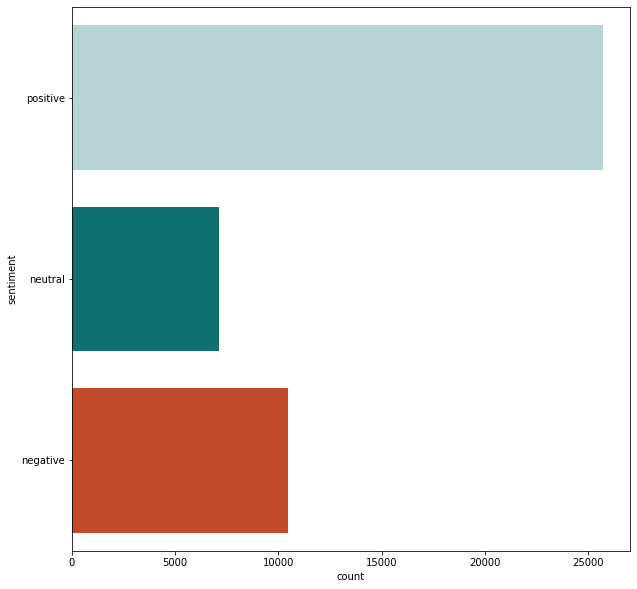

In [294]:
#Visualize data
# Number of tweets 
sns.countplot(y='sentiment', 
             data=df, 
             palette=['#b2d8d8',"#008080", '#db3d13']
             )

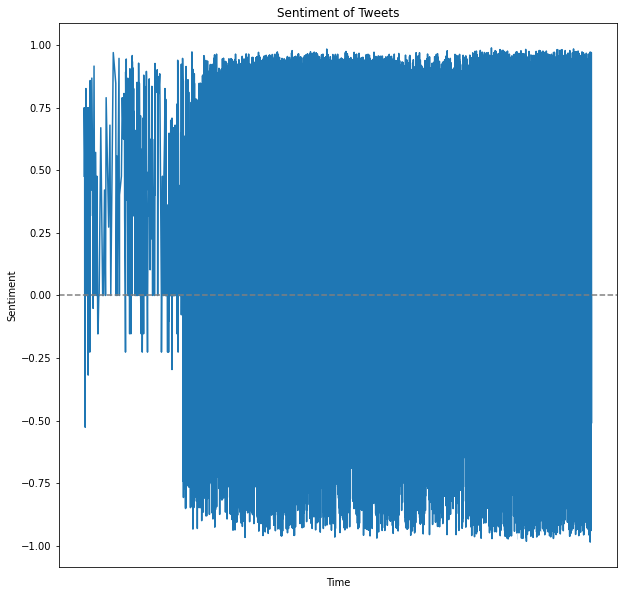

In [299]:
# Lineplot
g = sns.lineplot(x='date', y='compound', data=df)

g.set(xticklabels=[]) 
g.set(title='Sentiment of Tweets')
g.set(xlabel="Time")
g.set(ylabel="Sentiment")
g.tick_params(bottom=False)

g.axhline(0, ls='--', c = 'grey')
#Dużo tweetów dlatego tak

<AxesSubplot:xlabel='sentiment', ylabel='compound'>

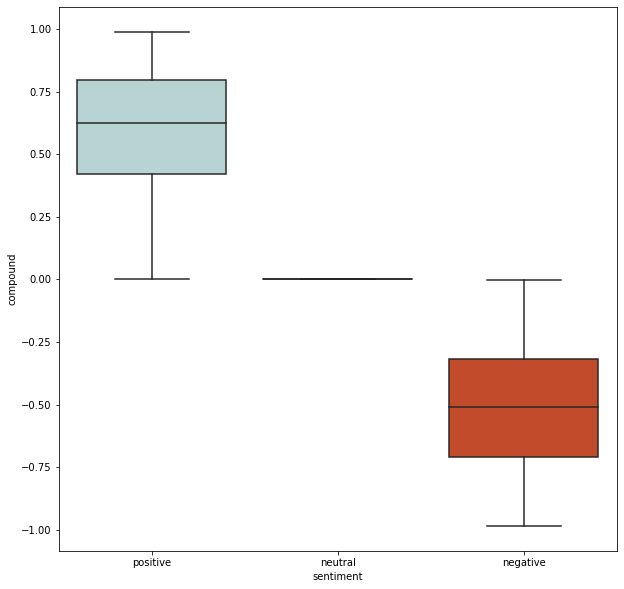

In [298]:
# Boxplot
sns.boxplot(y='compound', 
            x='sentiment',
            palette=['#b2d8d8',"#008080", '#db3d13'], 
            data=df)